## **Notebook 2: Noise in CCD images**

*Learning outcomes*
- We will learn about the different noise components that make up an astronomical CCD image:
    - dark current
    - read noise
    - sky noise
    - pixel-by-pixel sensitivity variations
    - fixed pattern noise
    - bias offset level
- We will learn how all these different components combine in a real image.
- We will study the effect of interactively changing different noise components on the image.

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
from useful_functions import plot_image

## **Blank image**
To start, we will construct an empty image, consisting of a two-dimensional array of zeros. The camera we will use for the noise simulations has the following specifications:
1) Number of active pixels: 1000 (Horizontal) $\times$ 1000 (Vertical)
2) Read noise: 10 electrons (root mean square).
3) Dark current: 0.1 electrons/s/pixel at a temperature of 30$^{\circ}$ C.
4) Pixel full well capacity: 50,000 electrons (maximum number of electrons one pixel can hold).
5) Pixel size: 4 $\mu$m (Horizontal) $\times$ 4 $\mu$m (Vertical)
6) Digital resolution: 16 bits

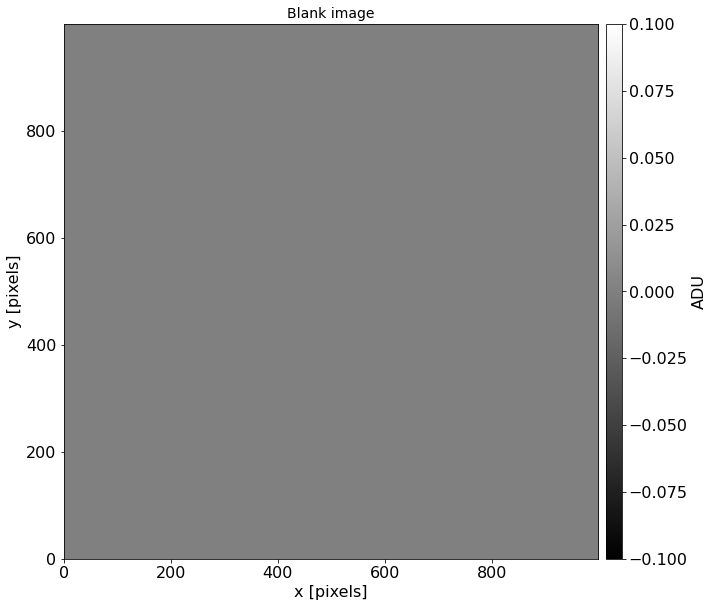

In [2]:
# Construct a blank image
pix_H = 1000 # number of active pixels in the horizontal direction
pix_V = 1000 # number of active pixels in the vertical direction

blank_image = np.zeros([pix_H, pix_V])

# plot the empty image using the plot_image convenience function
plot_image(image=blank_image,
          title='Blank image')

## **Read noise**
- Readout noise (or read noise) is the number of electrons introduced per pixel due to the readout of the device. 
- Read noise consists of two inseparable components:
    1) The conversion of an analog signal (voltage across a capacitor) to a digital number (ADU) is not perfectly repeatable. Each on-chip amplifier and the analog-to-digital converter (ADC) will produce a statistical distribution of values that is centered around a mean value. So, even for the case of reading the same pixel twice (each time with identical charge), a slightly different answer may be produced. 
    2) The electronics themselves will introduce spurious electrons into the process, leading to random fluctuations in the output. 

- Read noise is roughly Gaussian distributed, where the *standard deviation* of the distribution is usually taken to be the read noise specification. 
- First, let's write a function to generate read noise. The function will take the read noise specification for the camera and the camera gain as the inputs. 
- The gain of the camera can be calculated using the full well capacity (number of electrons one pixel can hold) and number of bits used in the digitization. For our reference camera, the full well capacity is 50,000 electrons. The digitization resolution is 16 bits, so the gain is

\begin{equation}
K = \frac{\text{Full well capacity}}{2^{\text{bits}}-1} = \frac{50000}{2^{16}-1} \simeq \text{0.76 [$e^{-}$/ADU]}
\end{equation}

- This means that for every 0.76 electrons collected by a pixel, 1 ADU is registered after digitization for that pixel.
- The function below will generate a different read noise array each time its run, so it operates like real read noise.

In [ ]:
def get_read_noise(image,
                   read_noise_std,
                   gain=1):
    """
    Generate read noise 2D array.
    
    Parameters
    input:
    image: numpy array
        Science image whose shape read noise array will match
    read_noise_std: float
        Read noise of the camera [electrons rms]
    gain: float (optional)
        Gain of the camera, [electrons/ADU]
    output:
        numpy array with read noise who shape matches input science 
        array
    """
    array_shape = image.shape
    read_noise_array = np.random.normal(loc=0,
                                        scale=read_noise_std/gain,
                                        size=array_shape)
    return read_noise_array

### **Exercise 1: Read noise only image**
- Using the read noise generating function above (`get_read_noise`), construct an image that contains read noise only.
- In the `get_read_noise` function 
  - Provide the `blank_image` constructed above as the `image` parameter
  - Provide the read noise and gain of the reference camera using the `read_noise_std` and `gain` parameters of the function.
- Plot the read noise only image using the `plot_image` function
  - Provide the `title` parameter of the `plot_image` function to be *'Read noise only'*.
- Notice that the read noise corresponds to both positve and negative counts, as expected from a Gaussian distribution with zero mean.
- Does the read noise depend on the exposure time of the camera? Why or why not?

In [ ]:
# Solution to Exercise 1
camera_gain = 0.76 # electron/ADU
read_noise_std = 10 # electrons RMS

## continue here

## **Bias**
- To ensure the conversion from voltage to digital counts (ADU) always results in non-negative counts, an offset voltage (called the **bias level**) is added to each pixel. Adding a constant voltage results in adding a constant offset to the counts for each pixel, which leads to pixel values that are all positive (even for a read noise only image).
- All CCD pixels will have a bias offset, and the bias level must be removed if the data values are to be truly representative of the counts recorded per pixel. In addition, there can be small variations in the bias level across the CCD pixels, and the bias level can also vary with time and temperature. It is also common to have certain columns and pixels in which the bias level is consistently offset from the rest of the chip.
- These so-called *bad* columns are typically stable over time, which allows for their correction in real data.
- A bias frame (or bias image) is an image taken with a zero exposure time to understand the bias level of the CCD.
- Below, we create a function to generate a bias level array given the science image and the bias value to add. We also have optional arguments to include bad columns and how many bad columns to include, if so.
- Does the bias level depend on the exposure time of the camera? Why or why not?

In [ ]:
def get_bias_level(image,
                   bias_value,
                   add_bad_columns=True,
                   num_columns=5):
    """
    Generate simulated bias 2D array.
    
    Parameters
    ----------
    image: numpy array
         Science image whose shape read noise array will match
    bias_value: float
         Bias value to add to the image [ADU]
    add_bad_columns: bool, optional
         Optional argument to add bad columns to the bias image. The
         bad columns will have higher bias level than the other pixels.
    num_columns: float
         Number of bad columns to add. Default is 5.
    output:
        numpy array with the bias level with shape matches input science 
        array
    """
    bias_im = np.zeros_like(image) + bias_value
    
    if add_bad_columns:
        rng = np.random.RandomState(seed=23) 

        columns = rng.randint(0, image.shape[1], size=num_columns)
        col_value = rng.randint(int(0.3*bias_value), 
                                int(.8*bias_value), 
                                size=image.shape[1])
        
        # Add additional brightness to random columns
        for column in columns:
            bias_im[:, column] = bias_value + col_value
    return bias_im

### **Exercise 2: Bias only image**
- Using the `get_bias_level` function above, construct an image with only the bias.
- Set `add_bad_columns` to `True`.
- Set the `bias_level` to 200.
- Set the number of bad columns using `num_columns` to 5.
- Plot the image

In [ ]:
# Solution of Exercise 2

## **Dark current**
- Electrons are excited into the conduction band by incoming photons (from the astronomical source) due to the photoelectric effect. In addition to the photoelectric effect, however, it is also possible to create electron-hole pairs due to *thermal excitation* of electrons into the conduction band, which are then also collected within the potential well of a pixel. These additional electrons lead to the so-called **dark current** in the CCD image.
- When the device is read out, these dark current electrons become part of the signal and are indistinguishable from electrons generated by photons from the astronomical source.
- Thermal generation of electrons in silicon is a strong function of temperature of the CCD. Therefore, CCDs for astronomical use often requires some form of cooling.
- CCDs are generally cooled with (i) liquid nitrogen, or (ii) thermoelectric cooling.
- Dark current is typically small (less than 1 electrons/second/pixel) and follows the Poisson distribution.
- For a small fraction of pixels, the dark current value is much greater than the rest of the pixels. Such pixels are called *hot pixels*. The dark current in hot pixels is stable over time, allowing for their subtraction in image cleaning. 
- Below, we write a function to simulate dark current that can be added to an image.

In [ ]:
def get_dark_current(image, 
                     dark_current,
                     exposure_time,
                     gain=1.0,
                     hot_pixels=False,
                     hot_pixels_percentage=0.1):
    """
    Generate simulated dark current 2D array.
    
    Parameters
    ----------
    image: numpy array
         Science image whose shape read noise array will match
    dark_current: float
         Dark current level [electrons/sec/pixel]
    exposure_time: float
         Exposure time of the image [seconds]
    gain: float, optional
         Camera gain [electron/ADU]
    hot_pixels: bool, optional
         Whether or not to add hot pixels to the image []
    hot_pixels_percentage: float, optional
         Percentage of hot pixels []
    output:
        numpy array with the dark current with shape matches the
        input science array
    """
    # get dark current level in ADU
    dark_adu = dark_current * exposure_time / gain
    
    # create a 2D sampled from a Poisson distribution
    dark_im = np.random.poisson(lam=dark_adu, size=image.shape)
    
    if hot_pixels:
        y_max, x_max = dark_im.shape
        n_hot = int((hot_pixels_percentage/100) * x_max * y_max)
        
        rng = np.random.RandomState(100)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        # set hot pixels to be 1000 times the dark current level
        hot_current = 1000 * dark_current
        
        for i in range(n_hot):
            dark_im[hot_x[i], hot_y[i]] = (hot_current  
                                           * exposure_time / gain)
    return dark_im

### **Exercise 3: Dark current only image**
- Using the `get_dark_current` function above, construct a dark current only image.
- Take the `dark_current` to be 0.1 electron per second per pixel. 
- Take the `exposure_time` to be 100 seconds.
- Plot the dark current only image.
- Turn on and off `hot_pixels` to see their effect on the image.
- Change the percentage of hot pixels by varying the `hot_pixels_percentage` parameter from 0.01% to 1%.
- Change the `exposure_time` to smaller and larger values to see the affect of exposure time on dark current.
- Does dark current increase or decrease with exposure time? Why?

In [ ]:
# Solution to Exercise 3
exposure_time = 100 # seconds
dark_current = 0.1 # e-/s/pixel

# continue here

## **Sky background**
The background night sky itself can also add signal to the CCD image. There are various sources that comprise the total sky background (see [Leinert et al. 1997](https://ui.adsabs.harvard.edu/abs/1998A%26AS..127....1L/abstract) for further details). 
1) **Zodiacal light**
- Caused by sunlight scattered from the diffuse cloud of interplanetary dust particles that lies primarily in the plane of the solar system.
- Function of the viewing direction, wavelength, heliocentric distance, and the position
of the observer relative to the symmetry plane of interplanetary dust.

2) **Airglow**
- Caused by the chemiluminescence of upper
atmosphere atoms and molecules.
- Function of zenith angle, local time, geographic latitude, season, solar activity, and
altitude. 

3) **Integrated starlight**
- Due to the combined light from unresolved stars in the Milky Way.
- Depends on the ability for the telescope to resolve stars, which is set by its limiting magnitude. 

4) **Diffuse Galactic light**
- Due to the diffuse component of the Galactic background radiation produced by scattering of starlight by interstellar dust. 

5) **Extragalactic background light**
- Due to redshifted starlight from unresolved galaxies, stars or gas
in intergalactic space, or redshifted emission from dust
particles heated by starlight in galaxies can also contribute to the total sky background.

Sky background noise is Poisson distributed. 

### **Exercise 4: Sky background noise generation function**
- Using the `get_dark_current` function as a reference, write a function called `get_sky_bkg` that will generate add sky noise to an image. 
- The sky background level follows the Poisson distribution and increases with exposure time, just like the dark current.
- The input parameters of the function should be:
    - `image`: (numpy array) image whose shape the sky noise image will match.
    - `sky_noise_electrons`: (float) sky noise level in [electrons per second per pixel].
    - `exposure_time`: (float) exposure time of the image [seconds].
    - `gain`: (float) gain of the camera [electron / ADU].
- The function should return a numpy array that has the sky background added to each array element (or in other words, each pixel) in ADU units.
- Using the function, plot a sky background only image for:
    - `sky_noise_electrons` = 0.5 electrons per second per pixel
    - `exposure_time` = 100 seconds

In [ ]:
# Solution to Exercise 4
def get_sky_bkg(image, 
                sky_noise_electrons,
                exposure_time,
                gain=1.0):    
    """
    Generate simulated sky background 2D array.
    Parameters
    ----------
    image: numpy array
         Science image whose shape read noise array will match
    sky_noise_electrons: float
         Sky background level [electrons/sec/pixel]
    exposure_time: float
         Exposure time of the image [seconds]
    gain: float, optional
         Camera gain [electron/ADU]
    output:
        numpy array with the sky background with shape matches the
        input science array
    """
    sky_adu = sky_noise_electrons * exposure_time / gain
    sky_im = np.random.poisson(lam=sky_adu, size=image.shape)
    return sky_im

camera_gain = 0.76 # electrons/ADU
sky_noise_electrons = 0.5 # electrons/s/pixel

sky_bkg_im = get_sky_bkg(image=blank_image,
                         sky_noise_electrons=sky_noise_electrons,
                         gain=camera_gain,
                         exposure_time=100)

plot_image(image=sky_bkg_im,
           title='Sky background image only')

### **Exercise 5: Flat field image**
- All pixels on the CCD do not have the same intrinsic sensitivity to electromagnetic radiation. There are intrinsic differences in light sensitivity from pixel to pixel. These differences are at a few percent level at most.
- Flat field images allow for the measurement of pixel-to-pixel variations in sensitivity across the CCD.
- Flat field images also allow for the measurement of two other effects:
    1) *Vignetting*: this is a reduction in the image's brightness near the edges of the image due to the optical system the CCD is attached to.
    2) *Dust*: dust on elements in the optical path like filters, the glass window covering the CCD, and the CCD chip itself can also block light. This often leads to the appearance of "donuts" in the image.
- Below, write a function `get_flat` that will provide uniformly distributed pixel-to-pixel sensitivity variations across the CCD.
- The input parameters of the function should be:
    - `image`: (numpy array) image whose shape the flat image will match
    - `percent_variations`: (float) the maximum percentage of sensitivity variations between the pixels
- Hint: the `numpy.randon.uniform` function is useful to sample from a uniform distribution, provided a `low` and `high` value to sample from, and the `size` or shape to return.
- Plot the flat image.

In [ ]:
# Solution to Exercise 5
def get_flat(image,
             percent_variations=5):
    """
    Generate a flat field image.
    
    Parameters
    ----------
    image: numpy array
         Science image whose shape read noise array will match
    percent_variations: float, optional
         Maximum percentage variation in pixel-to-pixel
         sensitivity []
    output:
        numpy array with the flat field with a shape that matches the
        input science array
    """
    # create a random seed to generate the same random image each time
    np.random.seed(0)
    
    # sample from a uniform distribution
    flat = np.random.uniform(low=1-(percent_variations/100),
                             high=1.0,
                             size=image.shape)
    return flat

flat = get_flat(image=blank_image,
                percent_variations=5)
plot_image(flat, 
           title='Flat field image only',
           interval_type='simple_norm',
           stretch='linear')

### **Exercise 6: Combined noise image**
- The total image on the CCD is a combination of the different components discussed above.
    - raw image = bias + read noise + dark current + flat $\times$ (sky + stars)
- Note that the pixel-by-pixel sensitivity variations reduce only the *incoming light* reaching the sensor. 
- Therefore, the flat image should be multiplied only the stars and sky components.
- Now, we will construct a noise image that contains all the noise components discussed above.
    - The image should include read noise, dark current, bias, and sky noise (with the pixel-to-pixel sensitivity variations included).
    - *Exposure time*: choose an exposure time of 100 seconds.
    - *Camera gain*: choose the camera gain to be 0.76 electrons per ADU.
    - *Dark current*: choose the dark current to be 1 electrons per second per pixel. For simplicity, do not add hot pixels to the image.
    - *Bias*: choose the bias level to be 200 ADU and include 5 bad columns.
    - *Read noise*: choose the read noise to be 10 electrons RMS.
    - *Sky noise*: choose the sky noise level to be 0.5 electrons per second per pixel. 
        - Multiply the sky noise level with a flat field image (assuming 5% uniformly distributed sensitivity pixel-by-pixel variations).
        - Hint, you can use `numpy.multiply(im_sky_noise, im_flat)` to multiply the sky noise array with the flat field array.
- Plot the combined noise image. Run the cell multiple times. Each iteration will generate a slightly different noise image.

In [ ]:
# Solution to Exercise 6
read_noise_std = 10 # electrons RMS
bias_value = 200 # bias offset in ADU
num_columns = 5 # number of bad bias columns
dark_current = 0.1 # electrons/s/pixel
sky_noise_electrons = 0.5 # electrons/s/pixel
exposure_time = 100 # seconds
percent_variations = 5 # percent
camera_gain = 0.76 # electron/ADU

# continue here



### **Exercise 7: Interactive noise image**
- Now, we will interactively display the noise image for varying noise parameters, using the different functions we have already created.
- We will use the `noise_image_interactive` function to do this. See `useful_functions.py` to see how the function works. This should lead to an interactive noise image.
- Change the various parameter values by sliding the slider to see their effect on the total noise image.

In [3]:
# Exercise 7 setup
from ipywidgets import interactive
from useful_functions import noise_image_interactive

noise_demo = interactive(noise_image_interactive, 
                   exposure_time=(0, 300, 20),
                   read_noise_std=(0, 20, 1),
                   dark_current=(0.0,3,0.1),
                   hot_pixels=False,
                   hot_pixels_percentage=(0, 1, 0.01),
                   bias_value=(0, 300, 10), 
                   num_bad_columns=(0, 10, 1),
                   sky_noise_electrons=(0, 5.1, 0.1),
                   percent_variations=(0,10,1),
                   plot_scale=['linear', 
                               'log',
                               'zscale',
                               'sqrt'])

for demo in noise_demo.children:
    try:
        demo.continuous_update = True
    except KeyError:
        pass
noise_demo

interactive(children=(IntSlider(value=200, description='bias_value', max=300, step=10), IntSlider(value=10, de…